<a href="https://colab.research.google.com/github/dvisionst/Project_1_Final/blob/main/Project_1_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 Core
- Jose Flores
- 6/29/2022

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import random
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn import set_config
set_config(display='diagram')



sales_data = "/content/sales_predictions.csv"
df = pd.read_csv(sales_data)
print(df.duplicated().sum())
df.head()
# no duplicated values

0


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [8]:
# creating a features matrix and target vector
y = df['Item_Outlet_Sales']
X = df.drop(columns=['Item_Outlet_Sales', 
                     'Item_Identifier', 
                     'Outlet_Identifier', 
                     'Outlet_Establishment_Year'])


X.isna().sum()

Item_Weight             1463
Item_Fat_Content           0
Item_Visibility            0
Item_Type                  0
Item_MRP                   0
Outlet_Size             2410
Outlet_Location_Type       0
Outlet_Type                0
dtype: int64

In [9]:
# Handling ordinal data, specifically Outlet size
replace_dict = {'High':2, 'Medium':1, 'Small': 0 }
df['Outlet_Size'].replace(replace_dict, inplace =True)
df['Outlet_Size'].head()

0    1.0
1    1.0
2    1.0
3    NaN
4    2.0
Name: Outlet_Size, dtype: float64

In [10]:
# performing the train and test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,NaN,Tier 2,Supermarket Type1


In [11]:
# Will start by making column selectors, imputers, and a scaler

cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Imputer

freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='median')
# scaler
scaler = StandardScaler()

# OHE

ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

I chose to use an impuder and encoder instead of dropping rows because of the amount of missing values. The data set itself has 8523 entries. The amount of missing values were 1463 for item weight and 2410 for outlet size. In percentage values those two represent 17% for weight and 28% for outlet size.
I beleive that is way too much to drop, so I chose to impute and encode instead. I used median imputation because most of the numerical data does not have a normal distribution.

In [12]:
# Instantiating a numeric pipeline

numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [13]:
# Instantiatin a categorical pipeline

categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [15]:
# Instantiating the column transfers and making preprocessor object
num_tuple = (numeric_pipe, num_selector)
cat_tuple = (categorical_pipe, cat_selector)

# Column transfer

preprocessor = make_column_transformer(num_tuple, cat_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff595b8ead0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff595b8e650>)])

In [16]:
# transforming the data starting with fitting training set

preprocessor.fit(X_train)

#transforming the training and testing sets
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_train_processed

array([[ 0.82748547, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.56664432, -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.12102782,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.12389588, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.77599877, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82748547, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])

# Final Part
This week, you will finalize your sales prediction project. The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in predicting sales.



## 1) Your first task is to build a linear regression model to predict sales.

* Build a linear regression model.
* Evaluate the performance of your model based on r^2.
* Evaluate the performance of your model based on rmse.


In [21]:
# creating the modeling pipeline with instantiated regression model

reg = LinearRegression()
# creating pipeline with the linear regression model
lin_reg_pipe = make_pipeline(preprocessor, reg)
# fitting model to training set
lin_reg_pipe.fit(X_train, y_train)



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff595b8ead0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ff595b8e650>)])),
                ('linearregression', LinearRegression())])

In [41]:
# Creating Model Predictions

train_prediction = lin_reg_pipe.predict(X_train)
test_prediciton = lin_reg_pipe.predict(X_test)

# Using sklearn to evaulate the model performance using R^2

train_R2 = round(r2_score(y_train, train_prediction) , 3)
test_R2 = round(r2_score(y_test, test_prediciton), 3)

print(f"The R^2 value for the Training Model is: {train_R2}")
print(f"The R^2 value for the Testing Model is: {test_R2}")

The R^2 value for the Training Model is: 0.561
The R^2 value for the Testing Model is: 0.565


In [23]:
# Using sklearn module to create MSE model for use in RMSE below 

train_MSE = mean_squared_error(y_train, train_prediction)
test_MSE = mean_squared_error(y_test, test_prediciton)

# Using sklearn module to apply RMSE metric to model 

train_RMSE = round(np.sqrt(train_MSE), 3)
test_RMSE = round(np.sqrt(test_MSE), 3)

print(f"Model for training RMSE:  {train_RMSE}")
print(f"Model for testing RMSE: {test_RMSE}")

Model for training RMSE:  1140.18
Model for testing RMSE: 1094.933


## 2) Your second task is to build a regression tree model to predict sales.

* Build a simple regression tree model.
* Compare the performance of your model based on r^2.
* Compare the performance of your model based on rmse.  


In [43]:
# Creating the decision tree and fitting to train data no scaling is needed
decision_tree = DecisionTreeRegressor(random_state = 42)

# # fitting the model
decision_tree.fit(X_train_processed, y_train)

train_pred = decision_tree.predict(X_train_processed)
test_pred = decision_tree.predict(X_test_processed)

In [45]:
# evaluating the model
train_score = round(decision_tree.score(X_train_processed, y_train), 3)
test_score = round(decision_tree.score(X_test_processed, y_test), 3)
print(train_score)
print(test_score)


1.0
0.129


In [46]:
# obtaining the depth for the decision tree model
decision_tree.get_depth()

41

In [48]:
# creating a loop in order to determine the optimal max depth for the model

levels = list(range(2, 41))

# storing the valuse of each max depth in a df
scores = pd.DataFrame(index=levels, columns=['Test Score', 'Train Score'])
# looping through levels list of depths

for depth in levels:
  decision_t = DecisionTreeRegressor(max_depth=depth, random_state=42)
  decision_t.fit(X_train_processed, y_train)
  train_score = decision_t.score(X_train_processed, y_train)
  test_score = decision_t.score(X_test_processed, y_test)
  scores.loc[depth, 'Train Score'] = train_score
  scores.loc[depth, 'Test Score'] = test_score

# sorting the values to identify the optimal max depth

sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

,Test Score,Train Score
5,0.594719,0.603925
6,0.58477,0.615131
4,0.584005,0.582625
7,0.580025,0.62677
8,0.569334,0.64272


In [50]:
# Using sklearn module to apply MSE metric to model 

decision_tree_5 = DecisionTreeRegressor(max_depth=5, random_state=42)
decision_tree_5.fit(X_train_processed, y_train)

train_5_score = round(decision_tree_5.score(X_train_processed, y_train), 3)
test_5_score = round(decision_tree_5.score(X_test_processed, y_test), 3)

print(train_5_score)
print(test_5_score)

0.604
0.595


In [53]:
# Using sklearn module to apply MSE metric to model 

dt_train_pred = decision_tree_5.predict(X_train_processed)
dt_test_pred = decision_tree_5.predict(X_test_processed)
train_MSE = round(mean_squared_error(y_train, dt_train_pred), 2)
test_MSE = round(mean_squared_error(y_test, dt_test_pred), 2)

# Using sklearn module to apply RMSE metric to model 

train_RMSE = round(np.sqrt(train_MSE), 3)
test_RMSE = round(np.sqrt(test_MSE), 3)

print(f"Model for training RMSE:  {train_RMSE}")
print(f"Model for testing RMSE: {test_RMSE}")

Model for training RMSE:  1082.666
Model for testing RMSE: 1057.431


## 3) You now have tried 2 different models on your data set. You need to determine which model to implement.

* Overall, which model do you recommend?
* Justify your recommendation.


*Neither model was anywhere close to ideal, however out of the two I would recommend using the decision tree model. The decision tree regression had higher R^2 scores for both the training and testing sets. They came in at 60.4% for training and 59.5% for testing set. As opposed to the linear regression model that had R^2 scores of 56.1% for training and  56.1% for testing. The decision tree model also scored much higher when using the RMSE metric with both sets havinf a smaller difference from each other. RMSE trainig and testing were 1082.7 and 1057.4 respectively. For the linear regression model the those values are 1140.2 and 1094.9. Using these two metrics it can be plainly seen that the decision tree outperforms the linear regression model.*

# Week 4 Portion

For Part 4, your task is to build several data visualizations to help your stakeholders better understand trends in the data. Feel free to get creative with this week - this is your chance to set your project apart from others with exceptional visualizations and analyses.

Build on your previous cleaning, exploration, and analysis.  
Create a minimum of two data visualizations that help others understand trends in the data (explanatory data analysis).
Since these graphs are for reporting purposes, make sure they look nice by including titles, legends, etc.
Commit your work to GitHub. 

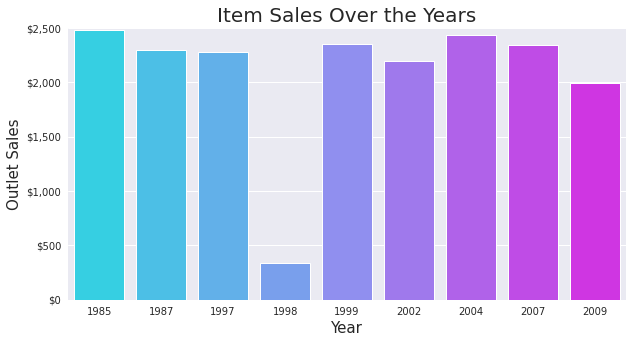

In [ ]:

fig, ax = plt.subplots(figsize=(10,5))
sns.set_theme(style="darkgrid")
plt.xlim(1985, 2009)
plt.ylim(0,2500)
price_fmt = mpl.ticker.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(price_fmt)
plt.title("Item Sales Over the Years", fontdict={"fontsize": 20})
sns.barplot(x="Outlet_Establishment_Year",
             palette='cool',
             y="Item_Outlet_Sales", 
             data=df, ci=None);
plt.ylabel("Outlet Sales", size=15);
plt.xlabel("Year", size=15);

The plot above shows that since 1985 the Outlet sales have remained fairly consistent outside of one year which was 1998.

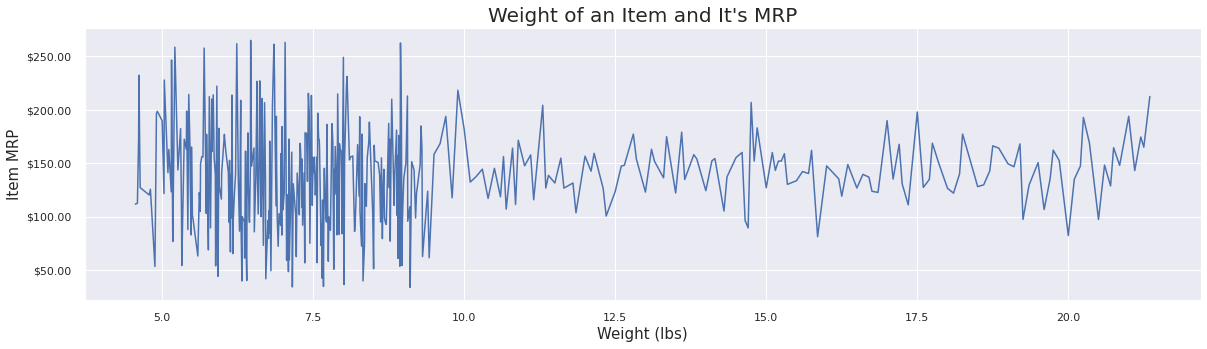

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))

# plt.xlim(0, 22)
# plt.ylim(0,2500)
price_fmt = mpl.ticker.StrMethodFormatter('${x:,.2f}')
ax.yaxis.set_major_formatter(price_fmt)
plt.title("Weight of an Item and It's MRP", fontdict={"fontsize": 20})
line = sns.lineplot(x="Item_Weight",
             y="Item_MRP", data=df, ci=None);
plt.ylabel("Item MRP", size=15);
plt.xlabel("Weight (lbs)", size=15);

plt.style.use(['dark_background']);

plt.rcParams['font.family'] = 'serif'

This plot shows the the weight vs the item MSRP. It can be seen that the heavier a product is, doesn't necassarily mean it has a higher MSRP. 